In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

In [2]:
# datadirs = ["Jan07-Jan10","Jan10-onward"]
datadirs = ["aapltwt"]

In [3]:
%%time
dfs = []
for datadir in datadirs:
    for root,dirs,files in os.walk(datadir):
        for file in files:
            if file == ".DS_Store": continue
            name = file.split("_")[0]
            print(name,root+"/"+file)
            df = pd.read_csv(root+"/"+file)
#             columns = df.columns
#             columns[:7] = ["datestr","twt","open","high","low","close","adjclose"]
#             df.columns = columns
            df["name"] = [name]*df.shape[0]
            dfs.append(df)

tweets aapltwt/tweets_AAPL.csv
CPU times: user 1.77 s, sys: 217 ms, total: 1.99 s
Wall time: 3.03 s


<string>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
df = pd.concat(dfs,axis=0)
df["twt"] = df["twt"].astype(str)
df["twtarr"] = df["twt"].apply(lambda text: text.lower().split())

In [8]:
print(df.shape)
df = df[df["datestr"].notnull()]
print(df.shape)

(221345, 10)
(221343, 10)


In [9]:
df["datestr"] = df["datestr"].astype(str)
print(df.shape)
df = df[df["datestr"] != ""]
print(df.shape)

(221343, 10)
(221343, 10)


In [10]:
df["date"] = df["datestr"].apply( \
    lambda date: datetime.strptime(date,"%m/%d/%y"))

Open, High, Low, Close, Adj Close

In [11]:
import gensim
%time w2vM = gensim.models.Word2Vec(df["twtarr"])

CPU times: user 57.1 s, sys: 971 ms, total: 58.1 s
Wall time: 34.2 s


In [12]:
# number of samples to aggregate
Ns = int(1e6)

In [13]:
%%time
# MEAN AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).mean(axis=0)
#                  for twt in df["twtarr"][:Ns]])
# tvecs = np.array([np.array([w2vM[t]
#                             for t in twt
#                             if t in w2vM]).mean(axis=0)
#                  for twt in df["twt"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])
# MEAN AGGREGATION
# %time df["twtvecs"] = df["twtarr"][:Ns].apply(\
#     lambda twt: np.array([w2vM[t] \
#                          if t in w2vM else np.zeros((100,)) \
#                          for t in twt]).mean(axis=0))
%time df["twtvecs"] = df["twtarr"][:Ns].apply(\
    lambda twt: np.array([w2vM[w] \
                          for w in twt\
                          if w in w2vM]).mean(axis=0))

/Users/aduriseti/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


CPU times: user 26.2 s, sys: 961 ms, total: 27.1 s
Wall time: 40.3 s
CPU times: user 26.2 s, sys: 963 ms, total: 27.2 s
Wall time: 40.3 s


In [14]:
print(df.shape)
%time veclens = df["twtvecs"].apply(lambda vec: int(np.prod(vec.shape)))
df_empty = df[veclens != 100]
%time df = df[veclens == 100]
print(df.shape)

(221343, 12)
CPU times: user 2.65 s, sys: 141 ms, total: 2.79 s
Wall time: 3.57 s
CPU times: user 49.8 ms, sys: 22.3 ms, total: 72.1 ms
Wall time: 141 ms
(221288, 12)


In [15]:
%%time
namedatedf = df[["date","name","open"]].groupby(["name","date"]).aggregate(lambda gp: tuple(set(gp))[0])
# datedf = df[["date","name","open"]].groupby(["date"]).aggregate(lambda gp: tuple(set(gp))[0])

for name in namedatedf.index.levels[0]:
    pval = namedatedf.loc[name,"open"].values.astype(float)
    up = ((pval[1:] - pval[:-1]) > 0).astype(int)
    up = list(up) + [0]
    namedatedf.loc[name,"openup"] = up

CPU times: user 106 ms, sys: 23.9 ms, total: 130 ms
Wall time: 185 ms


In [16]:
%%time
namedategps = df[["date","name","twtvecs"]].groupby(["name","date"])
# namedatekeys = [k for k,gp in namedategps]
namedatevecs = [np.mean(gp.values[:,2],axis=0) for k,gp in namedategps]

CPU times: user 1.32 s, sys: 46.3 ms, total: 1.36 s
Wall time: 1.75 s


In [17]:
%%time
namedatedf["namedatevecs"] = namedatevecs

CPU times: user 1.36 ms, sys: 67 µs, total: 1.43 ms
Wall time: 2.04 ms


In [18]:
%%time
df["openup"] = df[["name","date"]].apply(\
    lambda nd: namedatedf.loc[(nd[0],nd[1]),"openup"],\
    axis = 1)

CPU times: user 2min 31s, sys: 4.52 s, total: 2min 35s
Wall time: 3min 24s


In [19]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

def roc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

In [20]:
namedatedf.iloc[-5:]

open  openup  \
name   date                            
tweets 2011-04-25  50.048573       1   
       2011-04-26  50.517143       0   
       2011-04-27  50.320000       0   
       2011-04-28  49.455715       1   
       2011-04-29  49.540001       0   

                                                        namedatevecs  
name   date                                                           
tweets 2011-04-25  [-0.0687514, 0.338717, -0.104983, 0.719003, 0....  
       2011-04-26  [-0.0638973, 0.228119, -0.0612518, 0.61137, 0....  
       2011-04-27  [-0.0596417, 0.442134, -0.0878261, 0.961118, 0...  
       2011-04-28  [-0.133262, 0.422511, -0.159304, 0.778825, 0.4...  
       2011-04-29  [-0.144797, 0.274585, -0.100934, 0.702119, 0.5...

# Average of tweets in a day

In [24]:
X = np.array([v for v in namedatedf["namedatevecs"]])
y = namedatedf["openup"].values
# inverse classifier
# y = 1 - y

In [25]:
print(X.shape,y.shape)

(237, 100) (237,)


In [26]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(X.shape[0]) < ratio
pidx = ~tidx

In [27]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

CPU times: user 34.1 ms, sys: 8.92 ms, total: 43 ms
Wall time: 45.8 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

TEST
Accuracy 0.54347826087 Precision 0.633333333333 Recall 0.655172413793 F1 0.64406779661
CPU times: user 4.48 ms, sys: 1.64 ms, total: 6.11 ms
Wall time: 5.89 ms
TRAIN
Accuracy 0.926701570681 Precision 0.902654867257 Recall 0.971428571429 F1 0.935779816514
CPU times: user 5.02 ms, sys: 965 µs, total: 5.99 ms
Wall time: 7.02 ms
ROC AUC


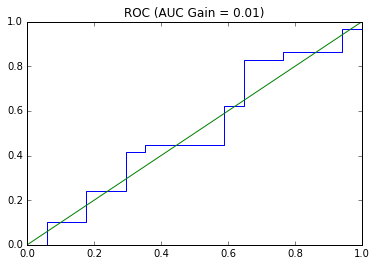

CPU times: user 268 ms, sys: 38.4 ms, total: 306 ms
Wall time: 601 ms
PRECISION/RECALL AUC


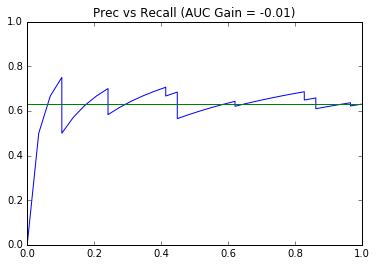

CPU times: user 325 ms, sys: 16.7 ms, total: 342 ms
Wall time: 664 ms


In [28]:
print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 21.9 ms, sys: 9.23 ms, total: 31.2 ms
Wall time: 40.1 ms
TEST
Accuracy 0.630434782609 Precision 0.630434782609 Recall 1.0 F1 0.773333333333
CPU times: user 1.03 ms, sys: 200 µs, total: 1.23 ms
Wall time: 1.22 ms
TRAIN
Accuracy 0.549738219895 Precision 0.549738219895 Recall 1.0 F1 0.709459459459
CPU times: user 2.11 ms, sys: 311 µs, total: 2.42 ms
Wall time: 2.7 ms
ROC AUC


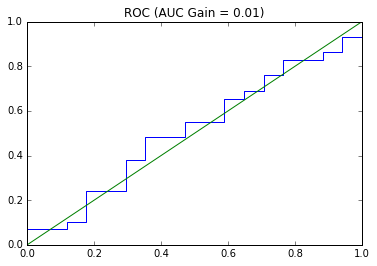

CPU times: user 257 ms, sys: 18.8 ms, total: 276 ms
Wall time: 290 ms
PRECISION/RECALL AUC


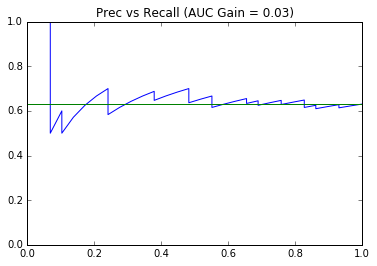

CPU times: user 240 ms, sys: 12.2 ms, total: 252 ms
Wall time: 281 ms


In [29]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


CPU times: user 12.8 ms, sys: 5.56 ms, total: 18.3 ms
Wall time: 19.1 ms
TEST
Accuracy 0.630434782609 Precision 0.630434782609 Recall 1.0 F1 0.773333333333
CPU times: user 2.81 ms, sys: 1.46 ms, total: 4.27 ms
Wall time: 4.67 ms
TRAIN
Accuracy 1.0 Precision 1.0 Recall 1.0 F1 1.0
CPU times: user 2.16 ms, sys: 432 µs, total: 2.59 ms
Wall time: 2.58 ms
ROC AUC


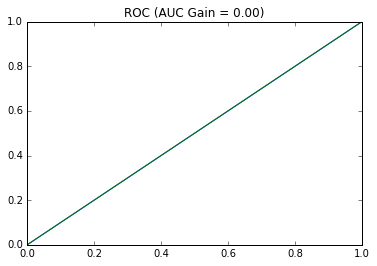

CPU times: user 237 ms, sys: 9.39 ms, total: 247 ms
Wall time: 250 ms
PRECISION/RECALL AUC


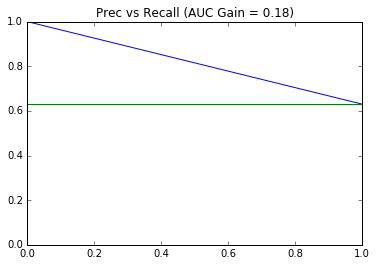

CPU times: user 284 ms, sys: 11 ms, total: 295 ms
Wall time: 375 ms


In [30]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

# Single tweets

In [31]:
# number of samples to train on
N = int(1e6)
X = np.array([x.T for x in df["twtvecs"][:N].values])
y = df["openup"][:N].values
# inverse classifier
# y = 1 - y

In [32]:
print(X.shape,y.shape)

(221288, 100) (221288,)


In [33]:
N

1000000

In [34]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(min(X.shape[0],N)) < ratio
pidx = ~tidx

CPU times: user 15.7 s, sys: 423 ms, total: 16.2 s
Wall time: 31.4 s
TEST
Accuracy 0.574834167214 Precision 0.570328755722 Recall 0.992157335907 F1 0.724301946622
CPU times: user 104 ms, sys: 98.2 ms, total: 203 ms
Wall time: 595 ms
TRAIN
Accuracy 0.578069863424 Precision 0.572730473327 Recall 0.992985370344 F1 0.72645746476
CPU times: user 265 ms, sys: 48.5 ms, total: 314 ms
Wall time: 505 ms
ROC AUC


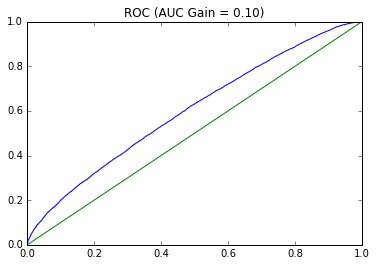

CPU times: user 352 ms, sys: 48.2 ms, total: 400 ms
Wall time: 569 ms
PRECISION/RECALL AUC


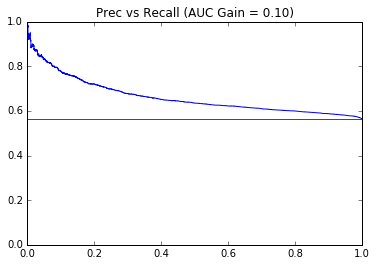

CPU times: user 383 ms, sys: 18.8 ms, total: 402 ms
Wall time: 639 ms


In [35]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 2min 21s, sys: 11.3 s, total: 2min 33s
Wall time: 3min 6s
TEST
Accuracy 0.700097348939 Precision 0.710155939072 Recall 0.789414414414 F1 0.747690608156
CPU times: user 174 ms, sys: 160 ms, total: 334 ms
Wall time: 419 ms
TRAIN
Accuracy 0.745783860386 Precision 0.748061875418 Recall 0.828456781476 F1 0.786209450733
CPU times: user 613 ms, sys: 504 ms, total: 1.12 s
Wall time: 2.17 s
ROC AUC


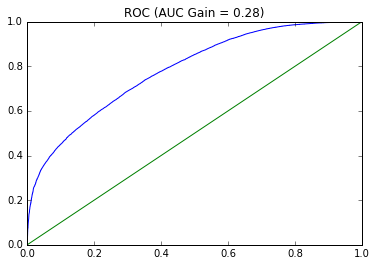

CPU times: user 396 ms, sys: 124 ms, total: 520 ms
Wall time: 559 ms
PRECISION/RECALL AUC


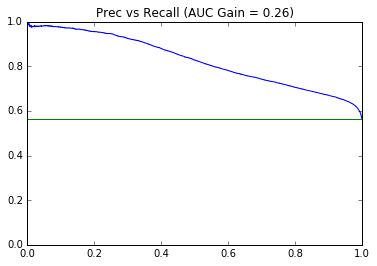

CPU times: user 389 ms, sys: 56 ms, total: 445 ms
Wall time: 584 ms


In [36]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 5.87 s, sys: 591 ms, total: 6.46 s
Wall time: 7.57 s
TEST
Accuracy 0.603337031084 Precision 0.659470963819 Recall 0.610641891892 F1 0.634117819032
CPU times: user 232 ms, sys: 177 ms, total: 409 ms
Wall time: 550 ms
TRAIN
Accuracy 0.61347019202 Precision 0.671490687968 Recall 0.616586947385 F1 0.642868693824
CPU times: user 1.1 s, sys: 829 ms, total: 1.93 s
Wall time: 2.76 s
ROC AUC


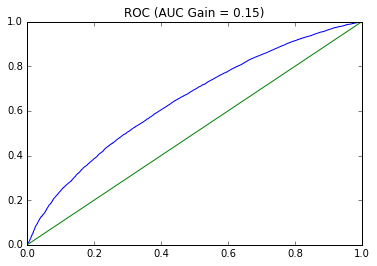

CPU times: user 527 ms, sys: 199 ms, total: 726 ms
Wall time: 964 ms
PRECISION/RECALL AUC


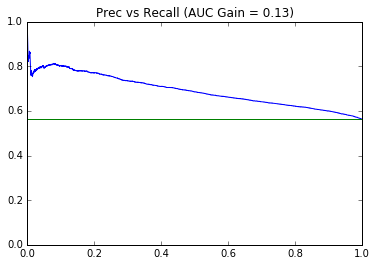

CPU times: user 508 ms, sys: 122 ms, total: 629 ms
Wall time: 814 ms


In [37]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])